# P6 - Notebook 3bis : Étude de Faisabilité - Clustering Images

## 1. Imports et Chargement des Données

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
import cv2
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

# 1. Chargement du fichier CSV qui contient les chemins des images et leurs catégories
df_images = pd.read_csv('Data/data_cleaned_for_images.csv')

# 2. Recréation de la variable true_labels_str
true_labels_str = df_images['main_category']

# 3. Recréer la variable n_clusters
n_clusters = df_images['main_category'].nunique()

# On recrée aussi les étiquettes numériques pour le score ARI
le = LabelEncoder()
true_labels = le.fit_transform(true_labels_str)


# Afficher un message pour confirmer que tout est prêt
print(f"Variables prêtes pour l'analyse :")
print(f"-> Nombre d'images : {len(df_images)}")
print(f"-> Nombre de clusters (n_clusters) : {n_clusters}")
print("-> Variable 'true_labels_str' créée.")

Variables prêtes pour l'analyse :
-> Nombre d'images : 1050
-> Nombre de clusters (n_clusters) : 7
-> Variable 'true_labels_str' créée.


## 2. Fonction d'Évaluation du Clustering

In [2]:
def analyser_et_visualiser_clustering(features, nom_algorithme, true_labels, true_labels_str, n_clusters):
    """
    Fonction finale qui :
    1. Calcule et affiche les scores ARI et NMI.
    2. Exécute KMeans sur les features originales.
    3. Réduit la dimension avec ACP pour la visualisation.
    4. Crée le graphique des catégories réelles.
    5. Crée le graphique des clusters prédits.
    6. Crée la matrice de contingence BRUTE (non réorganisée).
    """
    print(f"--- Analyse pour l'algorithme : {nom_algorithme} ---")

    # --- Étape 1 : Clustering et Calcul des Scores ---
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters_predits = kmeans.fit_predict(features)

    ari = adjusted_rand_score(true_labels, clusters_predits)
    nmi = normalized_mutual_info_score(true_labels, clusters_predits)
    print(f"Résultats -> ARI: {ari:.3f}, NMI: {nmi:.3f}\n")

    # --- Étape 2 : Réduction ACP pour la visualisation ---
    pca = PCA(n_components=2, random_state=42)
    features_2d = pca.fit_transform(features)

    # --- Étape 3 : Création du DataFrame pour les graphiques ---
    df_viz = pd.DataFrame({
        'x': features_2d[:, 0],
        'y': features_2d[:, 1],
        'true_category': true_labels_str,
        'predicted_cluster': clusters_predits.astype(str)
    })

    # --- Étape 4 : Graphique des vraies catégories ---
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_viz, x='x', y='y', hue='true_category', palette='viridis', alpha=0.7)
    plt.title(f'Visualisation des Vraies Catégories (ACP sur {nom_algorithme})')
    plt.show()

    # --- Étape 5 : Graphique des clusters prédits ---
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_viz, x='x', y='y', hue='predicted_cluster', palette='viridis', alpha=0.7)
    plt.title(f'Clusters Prédits par KMeans (ACP sur {nom_algorithme})')
    plt.legend(title='Cluster Prédit')
    plt.show()

    # --- Étape 6 : Matrice de Contingence ---
    contingency_matrix = pd.crosstab(df_viz['true_category'], df_viz['predicted_cluster'])

    column_order = contingency_matrix.idxmax(axis=0).sort_values().index
    contingency_matrix_sorted = contingency_matrix[column_order]

    # Affichage de la heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(contingency_matrix_sorted, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de Contingence Ordonnée pour {nom_algorithme}')
    plt.xlabel('Cluster Prédit par KMeans (Réorganisé)')
    plt.ylabel('Catégorie Réelle')
    plt.show()

## 3. ORB

In [3]:
# Charger le DataFrame contenant les chemins des images et les catégories
df_images = pd.read_csv('Data/data_cleaned_for_images.csv')
image_paths = df_images['image_path']
true_labels_str = df_images['main_category'] # Pour les graphiques
n_clusters = len(df_images['main_category'].unique())

# --- Étape 1 : Extraire les descripteurs ORB de toutes les images ---
print("Étape 1/3 : Extraction des descripteurs ORB...")
orb = cv2.ORB_create(nfeatures=500)
all_descriptors = []

for img_path in tqdm(image_paths):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            kp, des = orb.detectAndCompute(img, None)
            if des is not None:
                all_descriptors.append(des)
    except Exception as e:
        print(f"Erreur avec l'image {img_path}: {e}")

# Concaténer tous les descripteurs en une seule grande liste
all_descriptors = np.concatenate(all_descriptors, axis=0)

# --- Étape 2 : Créer le vocabulaire visuel avec KMeans ---
print("\nÉtape 2/3 : Création du vocabulaire visuel...")
k = 200 # Taille du vocabulaire visuel (hyperparamètre à ajuster)
kmeans_vocab = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_vocab.fit(all_descriptors)
print("Vocabulaire créé.")

# --- Étape 3 : Créer les histogrammes de features pour chaque image ---
print("\nÉtape 3/3 : Création des features finales (histogrammes)...")
orb_features = np.zeros((len(image_paths), k), "float32")

for i, img_path in enumerate(tqdm(image_paths)):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            kp, des = orb.detectAndCompute(img, None)
            if des is not None:
                words = kmeans_vocab.predict(des)
                for word in words:
                    orb_features[i][word] += 1
    except Exception as e:
        print(f"Erreur (étape 3) avec l'image {img_path}: {e}")

print("Extraction des features ORB terminée.")

Étape 1/3 : Extraction des descripteurs ORB...


100%|██████████| 1050/1050 [00:19<00:00, 52.51it/s]



Étape 2/3 : Création du vocabulaire visuel...
Vocabulaire créé.

Étape 3/3 : Création des features finales (histogrammes)...


100%|██████████| 1050/1050 [00:22<00:00, 47.67it/s]

Extraction des features ORB terminée.


--- Analyse pour l'algorithme : ORB + Bag of Visual Words ---
Résultats -> ARI: 0.027, NMI: 0.048



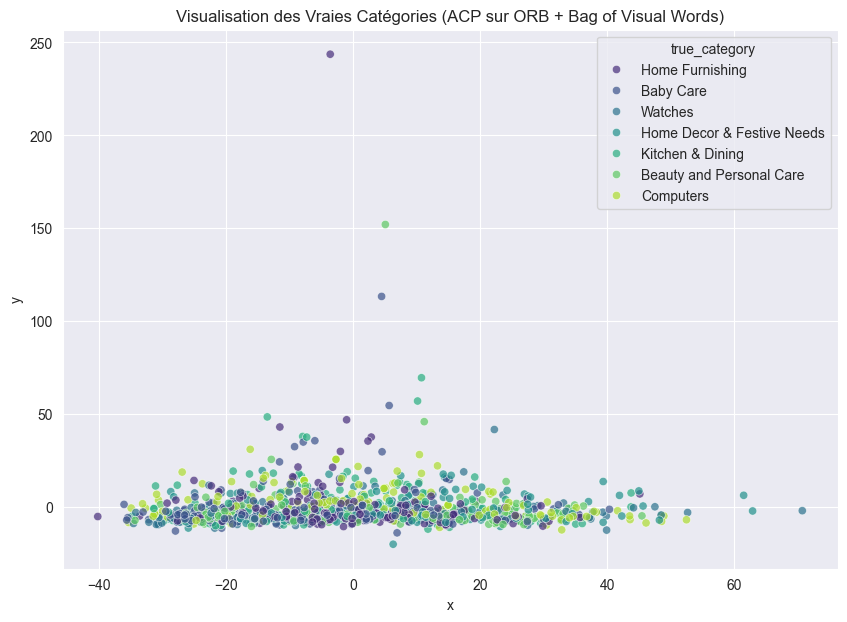

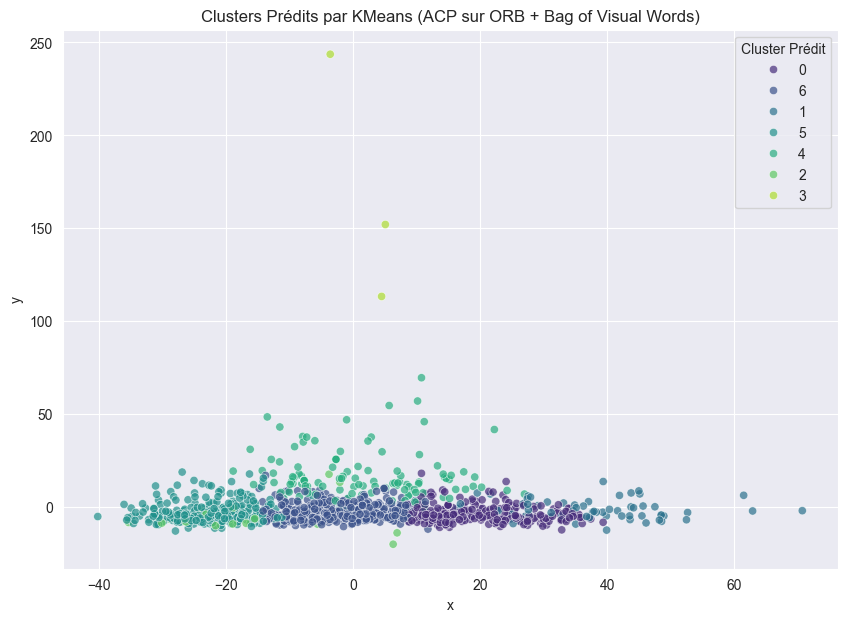

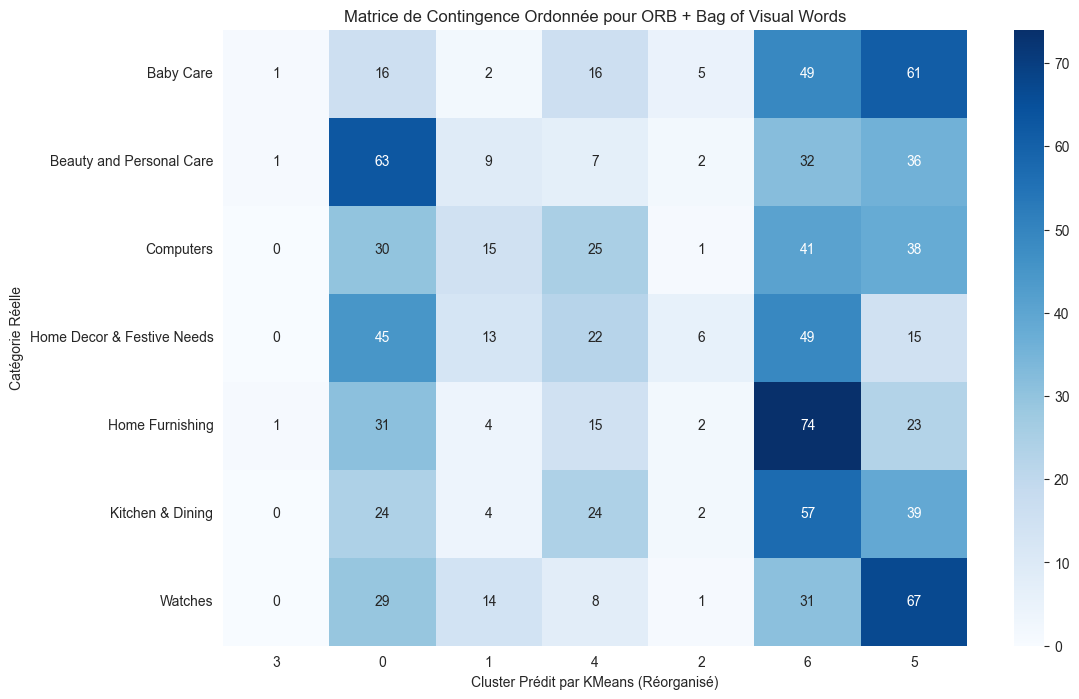

In [4]:
analyser_et_visualiser_clustering(orb_features, "ORB + Bag of Visual Words", true_labels, true_labels_str, n_clusters)

## 4. CNN ResNet50

In [5]:
# --- Étape 1 : Charger le modèle ResNet50 pré-entraîné ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor_model = Model(inputs=base_model.input, outputs=x)

# --- Étape 2 : Extraire les features pour chaque image ---
print("Extraction des features avec ResNet50...")
cnn_features = []

for img_path in tqdm(image_paths):
    try:
        # Charger et pré-traiter l'image pour ResNet50
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array_expanded = np.expand_dims(img_array, axis=0)
        img_preprocessed = tf.keras.applications.resnet50.preprocess_input(img_array_expanded)

        # Extraire les features
        features = feature_extractor_model.predict(img_preprocessed, verbose=0)
        cnn_features.append(features.flatten())
    except Exception as e:
        print(f"Erreur avec l'image {img_path}: {e}")
        # Ajouter un vecteur de zéros en cas d'erreur pour garder la dimension
        cnn_features.append(np.zeros(feature_extractor_model.output_shape[1]))

cnn_features = np.array(cnn_features)
print("Extraction des features CNN terminée.")

Extraction des features avec ResNet50...


 64%|██████▍   | 677/1050 [01:03<00:35, 10.55it/s]C:\Users\Thomas\Documents\Data_Science\Projet NLP\.venv\Lib\site-packages\PIL\Image.py:3452: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [01:39<00:00, 10.58it/s]

Extraction des features CNN terminée.


--- Analyse pour l'algorithme : CNN (ResNet50) ---
Résultats -> ARI: 0.463, NMI: 0.587



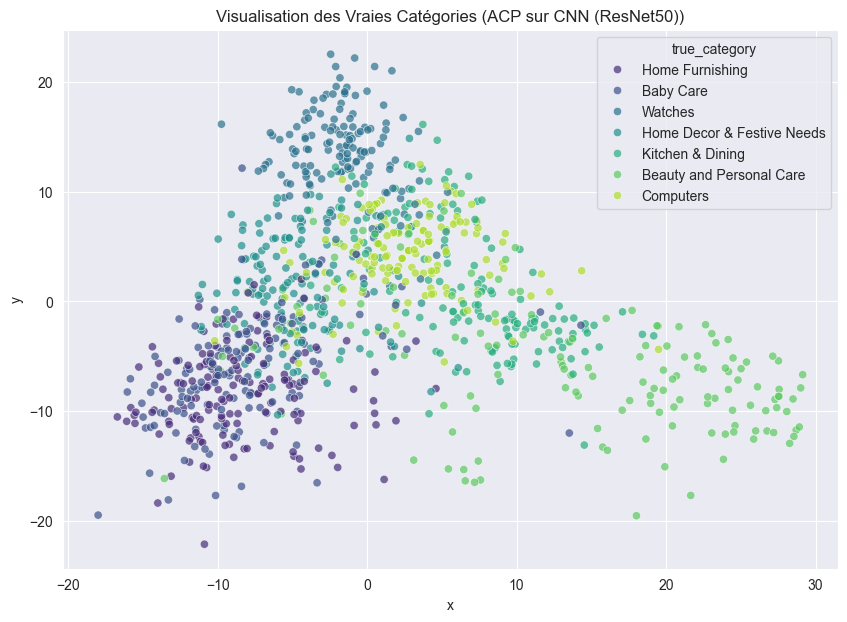

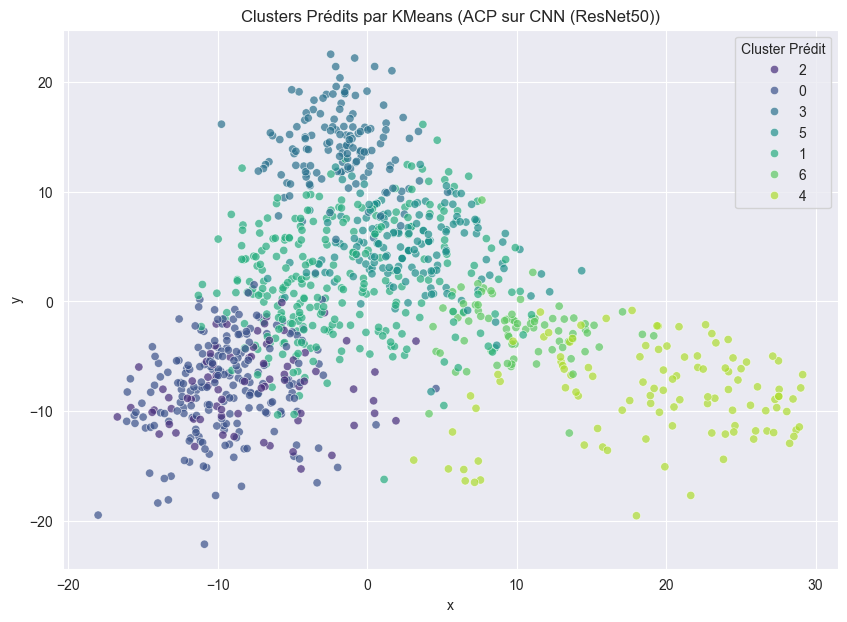

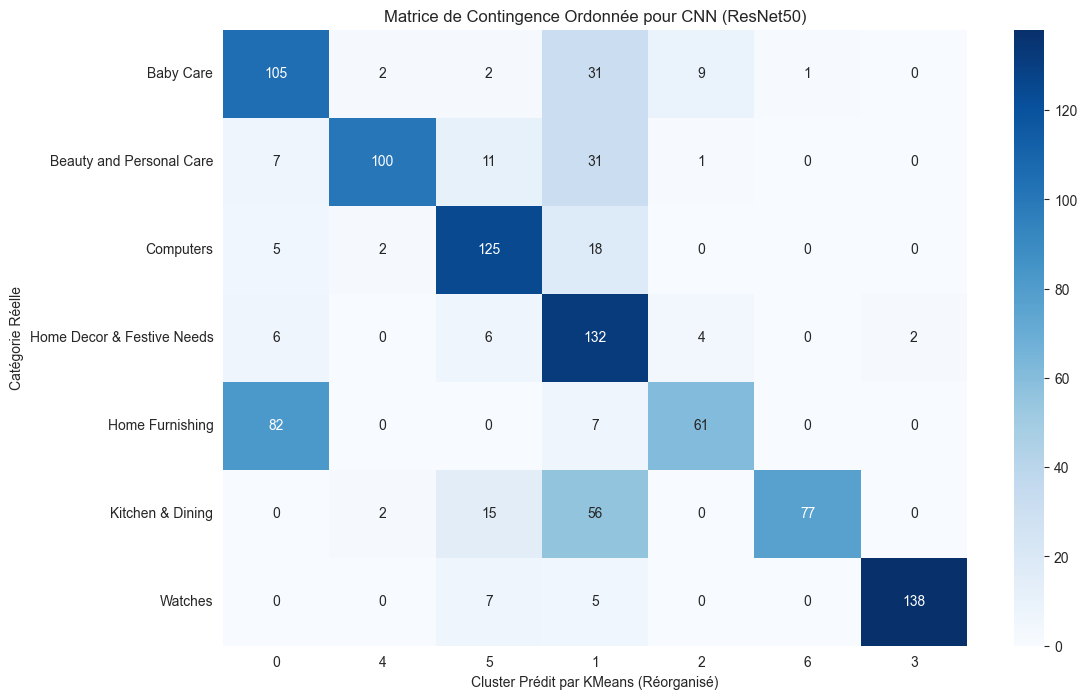

In [6]:
analyser_et_visualiser_clustering(cnn_features, "CNN (ResNet50)", true_labels, true_labels_str, n_clusters)

## 5. Conclusion de l'Étude de Faisabilité

L'étude de faisabilité est un succès. Le CNN (ResNet 50) obtient ici un score ARI de 0.46, indiquant des regroupements de produits plutôt cohérents. Cela valide la pertinence des images pour un futur modèle de classification.